### Generate a forcing data file

In [17]:
%matplotlib inline 

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr

#### Read a World Ocean Database (WOD) nc file (rectangle near to the eastern part of the Wadden Sea) which is produced by Ocean Data Viewer (ODV) and smooth through years for depths less then 11 m, var1 is depth

We use data from the top layer for all layers ( < 11m) since there are not enough data in other layers (checked in the 1st notebook)

In [18]:
ds = xr.open_dataset('wadden_sea.nc')
df = ds.to_dataframe()
df = df[(df.date_time > '2000-01-01 00:00:00.0') & (df.var1 < 11)]
df = df[['longitude', 'latitude', 'date_time'
        ,'var1', 'var2', 'var3', 'var4', 'var5', 'var6', 'var7'
        ,'var8', 'var9', 'var10', 'var11', 'var12', 'var13', 'var14']]
df.columns = ['longitude', 'latitude', 'date_time'
             ,'Depth', 'Temperature', 'Salinity', 'Oxygen', 'Phosphate', 'Silicate', 'Nitrate'
             ,'Nitrite', 'pH', 'Chlorophyll a', 'Plankton biomass', 'Alkalinity', 'NO2+NO3', 'pCO2']
df['Oxygen'] = df['Oxygen']*44.661 # 1 ml/l = 10^3/22.391 = 44.661 μmol/l
df['Day of year'] = df.date_time.dt.dayofyear.values

#### Make a mean year from a range of 11 years

In [19]:
dfyear = df[(df.date_time > '2000-01-01 00:00:00.0') & (df.date_time < '2011-01-01 00:00:00.0')]
dfyear = dfyear.groupby(['Day of year']).mean()
dfyear = dfyear.reindex(index=range(1,366))

In [20]:
dfyear = dfyear.interpolate(method='linear',limit_direction='forward')
dfyear.loc[0:16,:] = dfyear[-1:].values
dfyear.loc[0:16,'Chlorophyll a'] = 0
dfyear = dfyear.interpolate(method='linear',limit_direction='both')
dfyear = dfyear.rolling(window=16).mean()
dfyear = dfyear.interpolate(method='linear',limit_direction='both')

#### Make three successive years from one and plot. Other parameters also will be produced for 3 succesive similar years to construct a nc file with input data for a fortran model which resolves water and sediments domains

In [21]:
df3years = dfyear.append([dfyear, dfyear])
df3years.index = range(1, len(df3years)+1)
df3years.index.name = "day"

#### Plot dfyear, just visualization

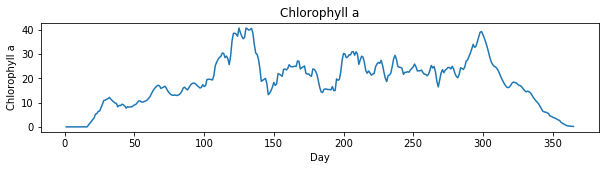

In [22]:
name = 'Chlorophyll a'
plt.plot(dfyear.index, dfyear[name]); plt.gcf().set_size_inches(10,2);
plt.title(name); plt.xlabel('Day'); plt.ylabel(name);

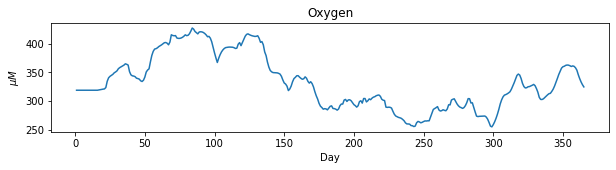

In [29]:
name = 'Oxygen'
plt.plot(dfyear.index, dfyear[name]); plt.gcf().set_size_inches(10,2);
plt.title(name); plt.xlabel('Day'); plt.ylabel('$\mu M$');

#### Generate PAR

In [24]:
# use a function described in utilities.py to generate a theoretical PAR
import utilities as ut
par_generated = np.zeros(365)
par_generated[:] = [ut.surface_radiation(x, 54) for x in range(365)]

In [25]:
par3years_generated = np.concatenate((par_generated, par_generated, par_generated), axis=None)

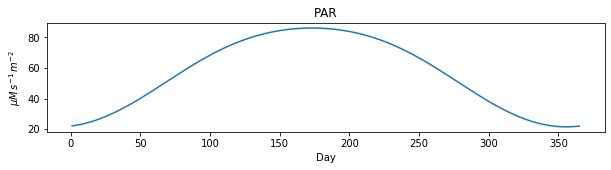

In [27]:
# visualize calculated PAR
name = 'PAR'; plt.plot(dfyear.index, par_generated);
plt.gcf().set_size_inches(10,2); plt.title(name);
plt.xlabel('Day'); plt.ylabel('$\mu M\,s^{-1}\,m^{-2}$');

#### Generate a north_sea_out.nc file which consist of 3 successive similar years

In [26]:
import utilities as ut
import itertools as it
from netCDF4 import Dataset

rootgrp = Dataset("north_sea_out.nc", "w", format='NETCDF3_CLASSIC')

levelface = rootgrp.createDimension("levelface", 3)
levelcntr = rootgrp.createDimension("levelcntr", 2)
time = rootgrp.createDimension("time", 1095)

times = rootgrp.createVariable("time","f8",("time",))
times.units = "seconds since 2010-01-01 00:00:00.0"
times.calendar = "gregorian"

par = rootgrp.createVariable("par","f4",("time",))
par.units = "microM photons m−2 s−1"

hice = rootgrp.createVariable("hice","f4",("time",))
snowthick = rootgrp.createVariable("snowthick","f4",("time",))
icesurft = rootgrp.createVariable("icesurft","f4",("time",))

levelsface = rootgrp.createVariable("levelface","f4",("levelface",))
levelsface.units = "m"
levelscntr = rootgrp.createVariable("levelcntr","f4",("levelcntr",))
levelscntr.units = "m"
temperature = rootgrp.createVariable("temperature","f8",("time","levelcntr",))
temperature.units = "C degrees"
salinity = rootgrp.createVariable("salinity","f8",("time","levelcntr",))
salinity.units = "psu"
sigma = rootgrp.createVariable("sigma","f8",("time","levelcntr",))
sigma.units = "kg m-1"
turbulence = rootgrp.createVariable("turbulence","f8",("time","levelface",))
turbulence.units = "m2 s-1"

ammonium = rootgrp.createVariable("ammonium","f8",("time","levelcntr",))
ammonium.units = "mM N m-3"
nitrate = rootgrp.createVariable("nitrate","f8",("time","levelcntr",))
nitrate.units = "mM N m-3"
sulfate = rootgrp.createVariable("sulfate","f8",("time","levelcntr",))
nitrate.units = "mM S m-3"
silicate = rootgrp.createVariable("silicate","f8",("time","levelcntr",))
silicate.units = "mM Si m-3"
phosphate = rootgrp.createVariable("phosphate","f8",("time","levelcntr",))
phosphate.units = "mM P m-3"
oxygen = rootgrp.createVariable("oxygen","f8",("time","levelcntr",))
oxygen.units = "mM O2 m-3"
om = rootgrp.createVariable("om_flux","f8",("time","levelcntr",))
om.units = "mg C m-3 s-1"
chl_a = rootgrp.createVariable("chl_a","f8",("time","levelcntr",))
chl_a.units = "mg Chl a"

lvlface = np.array([2.5, 1.25, 0])
lvlcntr = np.array([1.875, 0.625])

levelsface[:] = lvlface
levelscntr[:] = lvlcntr

times[:] = df3years.index.values * 24 * 60 * 60
par[:] = par3years_generated
hice[:] = 0
snowthick[:] = 0
icesurft[:] = 0
temperature[:,:] = np.vstack((df3years.Temperature.values, df3years.Temperature.values)).T
salinity[:,:] = np.vstack((df3years.Salinity.values, df3years.Salinity.values)).T

#### Calculate eddy diffusivity, see utilities.py

In [27]:
sigma[:,0] = [ut.svan(s,t,p) for s,t,p in 
              zip(df3years.Salinity.values, df3years.Temperature.values, it.count(lvlcntr[0]))]
sigma[:,1] = [ut.svan(s,t,p) for s,t,p in 
              zip(df3years.Salinity.values, df3years.Temperature.values, it.count(lvlcntr[1]))]

In [28]:
sigmaface = np.zeros((1095,3))
sigmaface[:,0] = [ut.svan(s,t,p) for s,t,p in 
              zip(df3years.Salinity.values, df3years.Temperature.values, it.count(lvlface[0]))]
sigmaface[:,1] = [ut.svan(s,t,p) for s,t,p in 
              zip(df3years.Salinity.values, df3years.Temperature.values, it.count(lvlface[1]))]
sigmaface[:,2] = [ut.svan(s,t,p) for s,t,p in 
              zip(df3years.Salinity.values, df3years.Temperature.values, it.count(lvlface[2]))]
turbulence[:,0] = ut.gargett(sigmaface[:,0], 1)
turbulence[:,1] = ut.gargett(sigmaface[:,1], 1)
turbulence[:,2] = ut.gargett(sigmaface[:,2], 1)

In [29]:
ammonium[:,:] = 0.1
sulfate[:,:] = 25000
nitrate[:,:] = np.vstack((df3years.Nitrate.values, df3years.Nitrate.values)).T
silicate[:,:] = np.vstack((df3years.Silicate.values, df3years.Silicate.values)).T
phosphate[:,:] = np.vstack((df3years.Phosphate.values, df3years.Phosphate.values)).T
oxygen[:,:] = np.vstack((df3years.Oxygen.values, df3years.Oxygen.values)).T

In [30]:
chl_a[:,:] = np.vstack((df3years['Chlorophyll a'].values, df3years['Chlorophyll a'].values)).T

In [31]:
om[:,:] = np.vstack((y_om/86400, y_om/86400)).T

In [32]:
rootgrp.close()